In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from chart_utils import etiquetas_porcentaje_categoria, etiquetas_porcentaje_total
%matplotlib inline  


In [2]:
from hogares import EncuestaHogares

encuesta = EncuestaHogares("usu_hogar_T324.xlsx", "usu_individual_T324.xlsx")
hogares, personas = encuesta.memoria()
hogares, personas = encuesta.filtrados_por_region(43, hogares, personas)
subconjunto_hogares, subconjunto_personas = encuesta.subconjunto_columnas(hogares, personas)
subconjunto_hogares_personas = encuesta.df_hogares_personas(subconjunto_hogares, subconjunto_personas)

### Edad
Cuantitativa discreta

In [3]:
personas["edad"].describe()
personas["edad"].std()/personas["edad"].mean()

np.float64(0.6011656842282621)

#### Valores Faltantes/Incorrectos
Hay 101 personas con edad -1.

In [4]:
len(personas[(personas["edad"]==-1)])

101

Se evalúa la fecha de nacimiento

In [7]:
estado = pd.DataFrame([
    (0, "Encuesta no realizada"),
    (1, "Ocupado"),
    (2, "Desocupado"),
    (3, "Inactivo"),
    (4, "Menor de 10 años")
], columns=["estado_actividad", "estado_nombre"])

nivel_educativo = pd.DataFrame([
    (1, "Primario incompleto (incluye educación especial)", 1),
    (2, "Primario completo", 2),
    (3, "Secundario incompleto", 3),
    (4, "Secundario completo", 4),
    (5, "Superior universitario incompleto", 5),
    (6, "Superior universitario completo", 6),
    (7, "Sin instrucción", 0),
    (9, "Ns/Nr", 9),
    ], columns=["nivel_educativo", "nivel_educativo_nombre", "nivel_educativo_orden"])

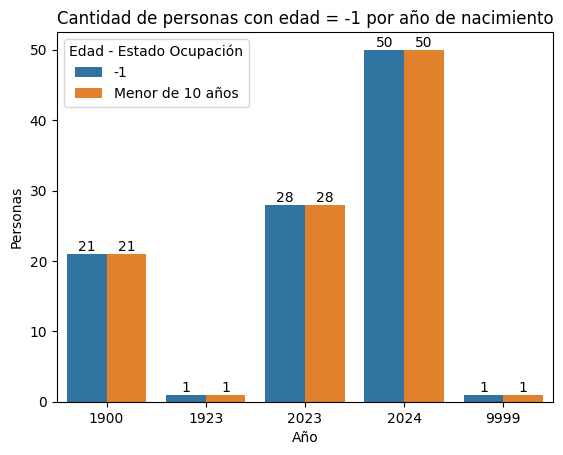

In [8]:
pd.options.mode.copy_on_write = True
ocurrencias_por_anio = pd.merge(personas[personas["edad"]==-1][["edad", "CH05", "estado_actividad"]], estado, on="estado_actividad")
ocurrencias_por_anio.loc[:, "año"] = ocurrencias_por_anio["CH05"].apply(lambda dt: dt.year)
ocurrencias_por_anio = pd.melt(ocurrencias_por_anio, id_vars=['año', "CH05", "estado_actividad"])
ocurrencias_por_anio

g = sns.countplot(data=ocurrencias_por_anio,  x="año", hue="value")
for i in g.containers:
    g.bar_label(i,)
g = g.set(xlabel='Año', ylabel='Personas')
g = plt.legend(title='Edad - Estado Ocupación', loc='upper left')
g = plt.title("Cantidad de personas con edad = -1 por año de nacimiento")


Se reemplazan los -1 por 0 asumiendo que las fechas de nacimiento correspondientes a los años 1900, 1923 y 9999 son errores de carga.

In [7]:
personas.loc[personas["edad"] == -1, "edad"] = 0

Se grafican la distribución de edades como histograma

In [9]:
personas[((personas["ingreso"]>0)|(personas["ingreso"].isnull()))&(personas["edad"]>=18)]["ingreso"].quantile([0.25,.75])

0.25    278000.0
0.75    800000.0
Name: ingreso, dtype: float64

In [10]:
alcance = personas[((personas["ingreso"]>0)|(personas["ingreso"].isnull()))&(personas["edad"]>=18)]
len(alcance)

7058

In [11]:
alcance.loc[alcance["ingreso"].isnull(),"ingreso"]=alcance["ingreso"].median()

In [12]:
alcance["ingreso"].describe()

count    7.058000e+03
mean     5.983204e+05
std      5.589073e+05
min      6.000000e+03
25%      2.798552e+05
50%      4.500000e+05
75%      8.000000e+05
max      1.237000e+07
Name: ingreso, dtype: float64

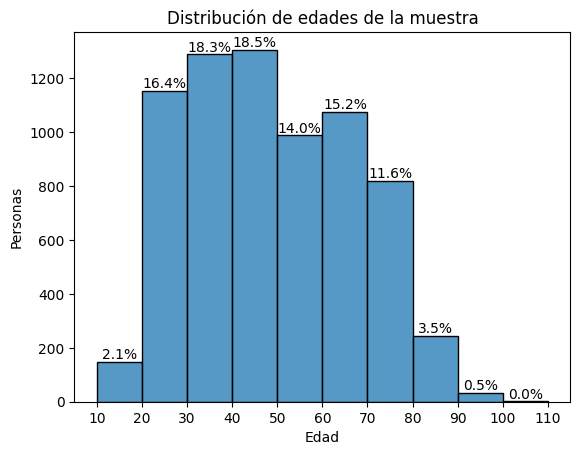

In [13]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots()
g = sns.histplot(data=alcance, x="edad", binwidth=10, binrange=(10,110), ax=ax)
for i in g.containers:
    etiquetas_porcentaje_total(g)
g.xaxis.set_major_locator(ticker.MultipleLocator(10))
g = g.set(xlabel='Edad', ylabel='Personas')
plt.title("Distribución de edades de la muestra")
plt.show()


In [13]:
alcance["ingreso"].quantile(.75)

np.float64(800000.0)

In [14]:
q1 = alcance["ingreso"].quantile(.25)
q3 = alcance["ingreso"].quantile(.75)
iqr = q3-q1 
mn = q1 -1.5*iqr
mx = q3 +1.5*iqr
print(mn, mx)
alcance_no_outliers = alcance[(alcance["ingreso"]>=mn)&(alcance["ingreso"]<=mx)]
alcance_no_outliers=pd.merge(alcance_no_outliers, estado, on="estado_actividad", how="inner")
alcance_no_outliers=pd.merge(alcance_no_outliers, nivel_educativo, on="nivel_educativo", how="inner")

-500361.875 1580217.125


In [58]:

alcance_no_outliers.loc[alcance_no_outliers["edad"]<20,"Grupo Edad"] = 18
alcance_no_outliers.loc[(alcance_no_outliers["edad"]>=20)&(alcance_no_outliers["edad"]<25),"Grupo Edad"] = 20
alcance_no_outliers.loc[(alcance_no_outliers["edad"]>=25)&(alcance_no_outliers["edad"]<30),"Grupo Edad"] = 25
alcance_no_outliers.loc[(alcance_no_outliers["edad"]>=30)&(alcance_no_outliers["edad"]<35),"Grupo Edad"] = 30
alcance_no_outliers.loc[(alcance_no_outliers["edad"]>=35)&(alcance_no_outliers["edad"]<40),"Grupo Edad"] = 35
alcance_no_outliers.loc[(alcance_no_outliers["edad"]>=40)&(alcance_no_outliers["edad"]<45),"Grupo Edad"] = 40
alcance_no_outliers.loc[(alcance_no_outliers["edad"]>=45)&(alcance_no_outliers["edad"]<50),"Grupo Edad"] = 45
alcance_no_outliers.loc[(alcance_no_outliers["edad"]>=50)&(alcance_no_outliers["edad"]<55),"Grupo Edad"] = 50
alcance_no_outliers.loc[(alcance_no_outliers["edad"]>=55)&(alcance_no_outliers["edad"]<60),"Grupo Edad"] = 55
alcance_no_outliers.loc[(alcance_no_outliers["edad"]>=60)&(alcance_no_outliers["edad"]<65),"Grupo Edad"] = 60
alcance_no_outliers.loc[(alcance_no_outliers["edad"]>=65)&(alcance_no_outliers["edad"]<70),"Grupo Edad"] = 65
alcance_no_outliers.loc[(alcance_no_outliers["edad"]>=70)&(alcance_no_outliers["edad"]<75),"Grupo Edad"] = 70
alcance_no_outliers.loc[(alcance_no_outliers["edad"]>=75)&(alcance_no_outliers["edad"]<80),"Grupo Edad"] = 75
alcance_no_outliers.loc[(alcance_no_outliers["edad"]>=80)&(alcance_no_outliers["edad"]<85),"Grupo Edad"] = 80
alcance_no_outliers.loc[(alcance_no_outliers["edad"]>=85)&(alcance_no_outliers["edad"]<90),"Grupo Edad"] = 85
alcance_no_outliers.loc[(alcance_no_outliers["edad"]>=90)&(alcance_no_outliers["edad"]<95),"Grupo Edad"] = 90
alcance_no_outliers.loc[(alcance_no_outliers["edad"]>=95)&(alcance_no_outliers["edad"]<100),"Grupo Edad"] = 95
alcance_no_outliers.loc[(alcance_no_outliers["edad"]>=100)&(alcance_no_outliers["edad"]<105),"Grupo Edad"] = 100

alcance_no_outliers.loc[alcance_no_outliers["sexo"]==1, "Género"] = "Hombre"
alcance_no_outliers.loc[alcance_no_outliers["sexo"]==2, "Género"] = "Mujer"

In [59]:
alcance_no_outliers["Grupo Edad"].value_counts()

Grupo Edad
40     661
30     634
25     614
35     605
45     546
60     535
20     528
65     498
50     496
70     466
55     420
75     333
80     153
18     147
85      86
90      28
95       5
100      1
Name: count, dtype: int64

Text(0, 0.5, 'Ingresos en pesos')

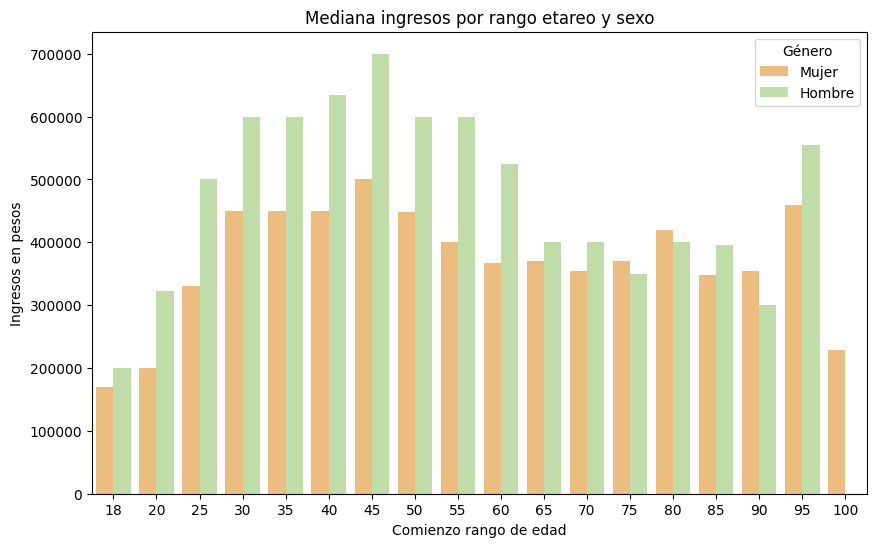

In [71]:
plt.figure(figsize=(10,6))

g=sns.barplot(alcance_no_outliers, x="Grupo Edad", y="ingreso", hue="Género", estimator="median", errorbar=None,palette="Spectral")
# plt.xticks(rotation=90, ticks=[18, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90,95, 100], labels=["[18,20)","[20,25)","[25,30)","[30,35)","[35,40)","[40,45)","[45,50)","[50,55)","[55,60)","[60,65)","[65,70)","[70,75)","[75,80)","[80,85)","[85,90)","[90,95)","[95,100)","[100,105)"])
# plt.legend(labels=["Hombre", "Mujer"])
# plt.xticks()
plt.title("Mediana ingresos por rango etareo y sexo")
plt.xlabel("Comienzo rango de edad")
plt.ylabel("Ingresos en pesos")
# g.errorbar()

# Transformación de la Variable Ingreso
Se reemplazan los valores nulos, causados por la encuesta no realizada, por la mediana y no se consideran las no respuestas de ingresos 2411.

In [36]:
personas[((personas["ingreso"]>0)|(personas["ingreso"].isnull()))&(personas["edad"]>=18)]["ingreso"].describe()
# aux.std()/aux.mean()

count    7.044000e+03
mean     5.986152e+05
std      5.594234e+05
min      6.000000e+03
25%      2.780000e+05
50%      4.500000e+05
75%      8.000000e+05
max      1.237000e+07
Name: ingreso, dtype: float64

In [24]:
personas.loc[personas["ingreso"].isnull(), "ingreso"] = personas[personas["ingreso"]!=-9]["ingreso"].median()

#### Ingresos por Edad 

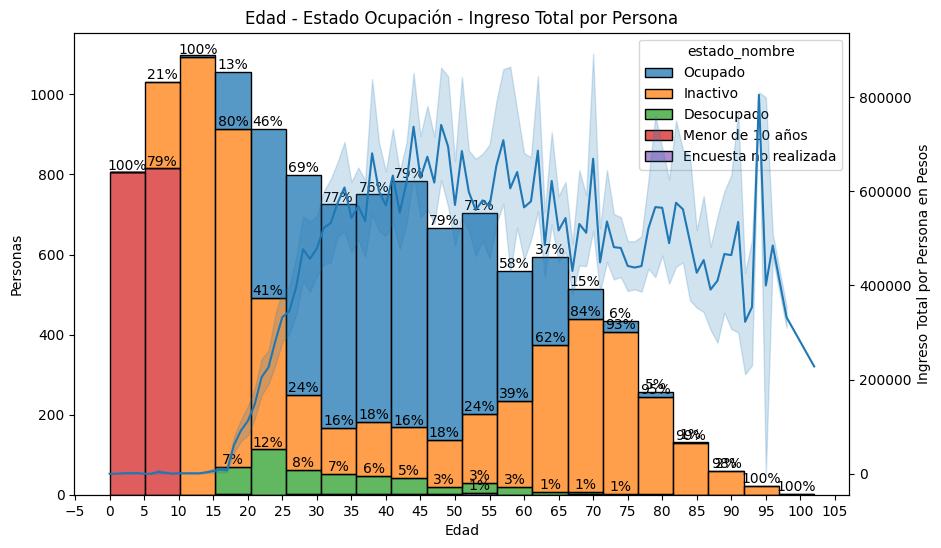

In [25]:
fig, ax = plt.subplots(figsize=(10,6))
personas_estado = pd.merge(personas[personas["ingreso"]!=-9], estado, on="estado_actividad")
g = sns.histplot(data=personas_estado, x="edad", binwidth=5, ax=ax, hue="estado_nombre", multiple="stack")
patches = []
etiquetas_porcentaje_categoria(ax)

g.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set(xlabel='Edad', ylabel='Personas')

ax2 = ax.twinx()  
sns.lineplot(data=personas_estado, x="edad", y="ingreso", ax=ax2)
ax2.set(ylabel='Ingreso Total por Persona en Pesos')
plt.title("Edad - Estado Ocupación - Ingreso Total por Persona")
plt.show()

#### Categorización de Variable Ingresos

In [27]:
personas.loc[personas["ingreso"]==0, "Rango Ingresos"] = "Sin Ingreso"
personas.loc[(personas["ingreso"]>0)&(personas["ingreso"]<=1000000), "Rango Ingresos"] = "0 - 1m"
personas.loc[(personas["ingreso"]>1000000), "Rango Ingresos"] = "+1m"

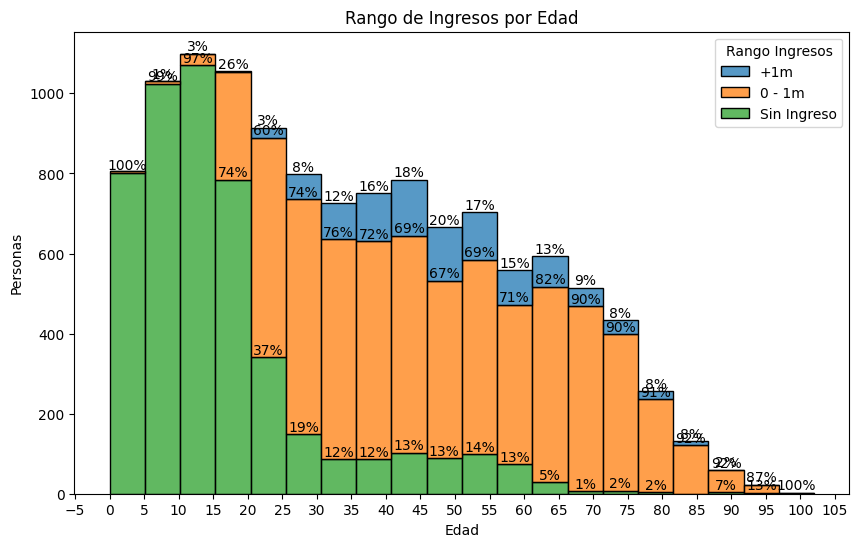

In [28]:
fig, ax = plt.subplots(figsize=(10,6))
g = sns.histplot(data=personas, x="edad", binwidth=5, ax=ax, hue="Rango Ingresos", multiple="stack")

etiquetas_porcentaje_categoria(ax)
g.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set(xlabel='Edad', ylabel='Personas')
plt.title("Rango de Ingresos por Edad")
plt.show()

### Análisis de no Respuestas para el Ingreso
#### Relación con el Nivel Educativo

In [17]:
nivel_educativo = pd.DataFrame([
    (1, "Primario incompleto (incluye educación especial)", 1),
    (2, "Primario completo", 2),
    (3, "Secundario incompleto", 3),
    (4, "Secundario completo", 4),
    (5, "Superior universitario incompleto", 5),
    (6, "Superior universitario completo", 6),
    (7, "Sin instrucción", 0),
    (9, "Ns/Nr", 9),
    ], columns=["nivel_educativo", "nivel_educativo_nombre", "nivel_educativo_orden"])

etiquetas = list(nivel_educativo.sort_values(by="nivel_educativo_orden")["nivel_educativo_nombre"])

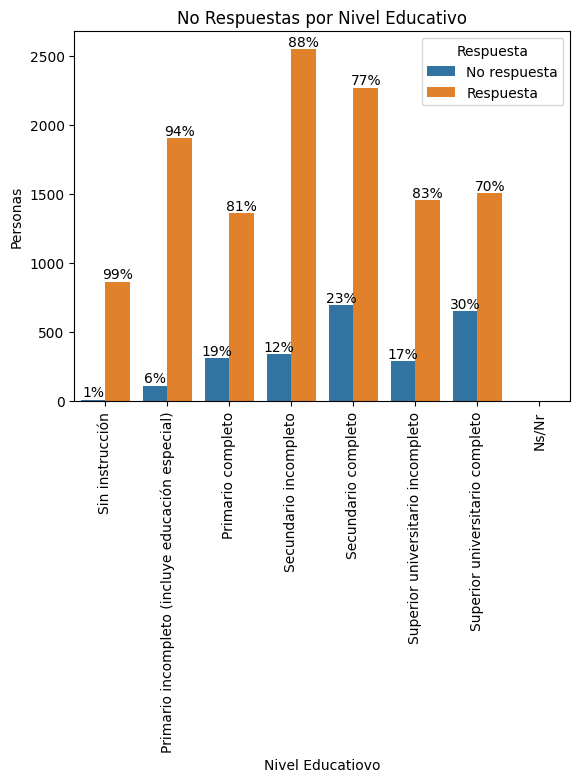

In [22]:
values = pd.merge(personas[["nivel_educativo", "ingreso"]],nivel_educativo, on="nivel_educativo")
values.loc[values["ingreso"]==-9, "Respuesta"] = "No respuesta"
values.loc[values["ingreso"]!=-9, "Respuesta"] = "Respuesta"
g = sns.countplot(data=values, x="nivel_educativo_nombre", hue="Respuesta", order=etiquetas)
etiquetas_porcentaje(g)
g.set(ylabel='Personas', xlabel="Nivel Educatiovo")
plt.title("No Respuestas por Nivel Educativo")
plt.xticks(rotation=90)
plt.show()